<a href="https://www.kaggle.com/code/markusayt/src-models-notebookea554506b2?scriptVersionId=162606177" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Blogpost: Working with tabular data

Start by reading the readme in https://github.com/Markustho/DAT255-group12 then come back

First a small introduction. The datasets are 2016 and 2017 data for a wind turbine and its sensor data. The sensor data appears to be capturing the time average, min and max values and storing them as seperate columns. In this project we only consider the T07 turbine, because this one has a failure of the bearing we are interested in validating our model against. It would be possible to train on all the data, but this was one of the possibilities we recognized, but did not manage to explore this time

This notebook aims to explore different methods and models for predicting the temperature. The emphesis is on showing how to proceed with applying one or more different models. Following the course DAT255 is used as background for the implementations we did.

Important background information is that hurt bearings have a few symptoms or measurable health indicators, which are production of noise, excessive temperature and vibration. By training the model on the healthy data, we want to validate different models and methods
against the data with the hurt bearing and hopefully see the deviation in the data.

# KAGGLE specifics

In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/LICENSE
/kaggle/input/.gitignore
/kaggle/input/pyproject.toml
/kaggle/input/README.md
/kaggle/input/poetry.lock
/kaggle/input/test_environment.py
/kaggle/input/.gitattributes
/kaggle/input/.DS_Store
/kaggle/input/reports/report.md
/kaggle/input/reports/.gitkeep
/kaggle/input/tests/__init__.py
/kaggle/input/models/valid_xs_final.pkl
/kaggle/input/models/splits.pkl
/kaggle/input/models/to.pkl
/kaggle/input/models/final_model.pkl
/kaggle/input/models/.gitkeep
/kaggle/input/models/final_data_train.pkl
/kaggle/input/models/xs_final.pkl
/kaggle/input/models/final_data_val.pkl
/kaggle/input/src/__init__.py
/kaggle/input/src/models/predict_model.py
/kaggle/input/src/models/na_summary.xlsx
/kaggle/input/src/models/.gitkeep
/kaggle/input/src/models/Notebook_blogpost_tabular_data.ipynb
/kaggle/input/src/models/__init__.py
/kaggle/input/src/models/testfile
/kaggle/input/src/models/outer_join.xlsx
/kaggle/input/src/models/Neural network/4_neural_network.ipynb
/kaggle/input/src/models/

In [13]:
#Check for colab or kaggle
try:
    import google.colab
    colab=True
except:
    colab=False

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [14]:
#check for internet on in kaggle if the client is run on kaggle
import socket,warnings
if kaggle:

    try:
        socket.setdefaulttimeout(1)
        socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
    except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [15]:
#If using FastAI, this will need to be ran to give latest version
"""if colab:
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book()

elif kaggle:
    !pip install -Uqq fastai"""

'if colab:\n    !pip install -Uqq fastbook\n    import fastbook\n    fastbook.setup_book()\n\nelif kaggle:\n    !pip install -Uqq fastai'

In [27]:
# Opening from different sources to allow for use of local IDE as well as run in kaggle
# Kaggle and local version is linked through github

from pathlib import Path
if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATA = Path('/content/gdrive/MyDrive/DAT255/')
    DATA.mkdir(exist_ok=True, parents=True)
    
elif kaggle:
    DATA = Path('/kaggle/input/data/raw/Onsite-MetMast-SCADA-data-2016.xlsx')
    DATAScada = Path("/kaggle/input/data/raw/Wind-Turbine-SCADA-signals-2016.xlsx")
    DATAFailures = Path("/kaggle/input/data/raw/Historical-Failure-Logbook-2016.xlsx")
    
    DATA17 = Path('/kaggle/input/data/raw/Onsite-MetMast-SCADA-data-2017.xlsx')
    DATAScada17 = Path("/kaggle/input/data/raw/Wind-Turbine-SCADA-signals-2017_0.xlsx")
    DATAFailures17 = Path("/kaggle/input/data/raw/opendata-wind-failures-2017.xlsx")

else:
    DATA17 = "../../data/raw/Onsite-MetMast-SCADA-data-2017.xlsx"
    DATAScada17 = "../../data/raw/Wind-Turbine-SCADA-signals-2017_0.xlsx"
    DATAFailures17 = "../../data/raw/opendata-wind-failures-2017.xlsx"
    
    #data from 2016
    DATA = "../../data/raw/Onsite-MetMast-SCADA-data-2016.xlsx"
    DATAScada = "../../data/raw/Wind-Turbine-SCADA-signals-2016.xlsx"
    DATAFailures = "../../data/raw/Historical-Failure-Logbook-2016.xlsx"

# Organizing data
Because we want to also try making our own splitter independent of if the data is in 2016 or 2017, we need to do most feature engineering for all the data

In general for both 2016 and 2017 we have:

> DATA = first dataset of information about the turbine

> DATAscada = second dataset of information about the turbine

> DATAFailures = data on when certain turbines had a failure happen, or maintenance activity

In [29]:
# opening excel file for processed data from 2016
try:
    data = pd.read_excel(DATA, engine='openpyxl')
    data17 = pd.read_excel(DATA17, engine='openpyxl')
except:
    data = pd.read_excel(DATA, engine='openpyxl')
    data17 = pd.read_excel(DATA17, engine="openpyxl")

In [30]:
# opening excel file for Scada data from 2016
datascada = pd.read_excel(DATAScada, engine='openpyxl')
datascada17= pd.read_excel(DATAScada17, engine="openpyxl")

Testing how to open and organize data using columns on failure dataset. This dataset is smaller, but is still based on time, so its good to do some tests on this one before the big datasets

In [31]:
# opening excel file for failures of all turbines in 2017
datafailures = pd.read_excel(DATAFailures, engine="openpyxl")

In [32]:
# sort by turbine T07
T07Failures = datafailures[datafailures["Turbine_ID"] == "T07"]
T07Failures # printing to show example of how how it looks. datafailures is only a small file

,Turbine_ID,Component,Timestamp,Remarks
7,T07,GENERATOR_BEARING,2016-04-30T12:40:00+00:00,High temperature in generator bearing (replace...
8,T07,TRANSFORMER,2016-07-10T03:46:00+00:00,High temperature transformer
9,T07,TRANSFORMER,2016-08-23T02:21:00+00:00,High temperature transformer. Transformer refr...


In [33]:
T07_scada_data = datascada[datascada["Turbine_ID"] == "T07"] # sorting data from T07 turbine from 2016
T07_scada_data17 =datascada17[datascada17["Turbine_ID"] == "T07"] 

We will now proceed with an inner join to get rid of NaN and missing data. Ideally we should try and do a mode replacement of the data at some point also. See Lesson 5 practical programming video with FastAI

In [34]:
#combining the data with respect to datetime. This is the inner join of enviromental data and turbine data for a respective timestamp
merged_df = pd.merge(T07_scada_data, data, on="Timestamp", how="inner") #2016

merged_df_outer_join = pd.merge(T07_scada_data,data, on="Timestamp", how="outer") #this one will have NaN and other imperfections. Modify at later stage



In [35]:
merged_df17 = pd.merge(T07_scada_data17, data17, on="Timestamp", how="inner") #2017


In [36]:
merged_df_outer_join.isna().sum().to_excel("outer_join.xlsx") #Just checking the scope of missing values. This command sums the amount of missing values for each column

Lets check how our data looks for our dependent variable:

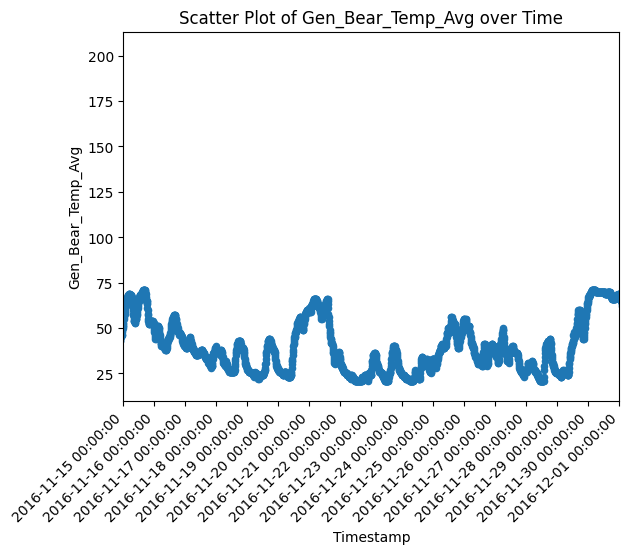

In [37]:
# plotting some data to look for outliers and anomalties in the data itself. Visualize the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#for i in merged_df:
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

ax = merged_df.plot.scatter(x="Timestamp", y="Gen_Bear_Temp_Avg")

# Customize the format of the timestamp on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# Optionally, set the locator for more control over tick placement
ax.xaxis.set_major_locator(mdates.DayLocator())  # You can adjust the locator based on your data frequency

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
#Define interval for data
plt.xlim(pd.Timestamp('2016-11-15'), pd.Timestamp('2016-12-01'))

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Gen_Bear_Temp_Avg')
plt.title('Scatter Plot of Gen_Bear_Temp_Avg over Time')

# Show the plot
plt.show()


Its nice to check for long tail distributions in the data itself. Here its possible to check all the different data for certain characteristics that can make it qualify for "Normalization" (logarithmic for example)

<Axes: >

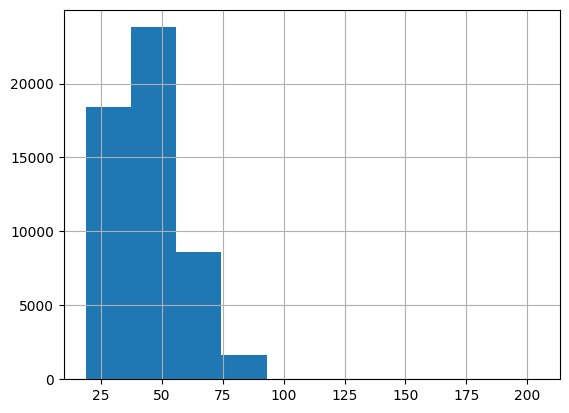

In [38]:
# check the "spread" of the data in a column
#this is interesting because often we do now want a long tail distribution of our data!
# for longtail distributions. make distribution logaritmic
merged_df["Gen_Bear_Temp_Avg"].hist()

The following code allows you to see all histograms

In [39]:
"""for col in merged_df.columns:
    merged_df[col].hist()
    plt.xlabel(col)  # Set x-axis label as column name
    plt.ylabel('Frequency')  # Set y-axis label as 'Frequency'
    plt.title(f'Histogram of {col}')  # Set title as 'Histogram of <column>'
    plt.show()  # Display each histogram"""

"for col in merged_df.columns:\n    merged_df[col].hist()\n    plt.xlabel(col)  # Set x-axis label as column name\n    plt.ylabel('Frequency')  # Set y-axis label as 'Frequency'\n    plt.title(f'Histogram of {col}')  # Set title as 'Histogram of <column>'\n    plt.show()  # Display each histogram"

# Data cleaning
Some cleaning of the data is neccesary like removing data that does not contain a number. We may also remove rows that we dont want, or combine datasets

In [40]:
from torch import tensor

Checking shape is great for vailidating for yourself that the data is in the correct format in respect to your model. Here we used it to see how many columns changed after doing certain data cleaning. 

remove turbine id to have only numbers in dataframe, drop na because its only  ~20 rows out of ~35000 when we were only analyzing the 2017 data

In [41]:


#merged_df.isnull().sum().to_excel('na_summary.xlsx')
merged_df.shape

(52442, 123)

remove turbine id to have only numbers in dataframe, drop na because its only  ~20 rows out of ~35000

In [42]:
#import torch

merged_df = merged_df.dropna()
merged_df = merged_df.drop("Turbine_ID", axis=1)

In [43]:
merged_df.shape

(52441, 122)

In [44]:
merged_df17

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,...,Anemometer1_CorrOffset,Anemometer2_Freq,Anemometer2_Offset,Anemometer2_CorrGain,Anemometer2_CorrOffset,DistanceAirPress,AirRessureSensorZeroOffset,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq
0,T07,2017-12-29T20:40:00+00:00,1255.5,1239.3,1248.8,2.9,39.0,63,63,63,...,0,0.0499,0.24,1,0,0,600,78,77,420
1,T07,2017-12-29T21:50:00+00:00,1253.6,211.8,819.4,499.1,38.0,57,58,57,...,0,0.0499,0.24,1,0,0,600,75,74,420
2,T07,2017-12-29T23:20:00+00:00,1259.1,1233.3,1249.5,3.4,36.0,59,59,59,...,0,0.0499,0.24,1,0,0,600,114,112,420
3,T07,2017-12-30T00:10:00+00:00,1269.0,1233.8,1250.0,5.4,37.0,61,61,61,...,0,0.0499,0.24,1,0,0,600,114,111,420
4,T07,2017-12-30T00:20:00+00:00,1334.9,1218.3,1254.0,18.1,37.0,61,61,61,...,0,0.0499,0.24,1,0,0,600,109,107,420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34577,T07,2017-05-31T06:30:00+00:00,1638.7,1274.4,1484.2,89.7,44.0,66,66,65,...,0,0.0499,0.24,1,0,0,600,167,157,408
34578,T07,2017-05-30T09:30:00+00:00,87.3,0.0,38.1,25.0,27.0,30,30,29,...,0,0.0499,0.24,1,0,0,600,23,22,408
34579,T07,2017-05-31T08:30:00+00:00,1771.8,1480.0,1640.1,49.1,62.0,102,101,99,...,0,0.0499,0.24,1,0,0,600,163,195,408
34580,T07,2017-05-31T09:40:00+00:00,1690.7,1511.8,1652.4,28.8,68.0,113,112,109,...,0,0.0499,0.24,1,0,0,600,152,181,408


Dropping the turbine_ID as we dont want to train on that column

In [45]:
merged_df17 = merged_df17.dropna()
merged_df17 = merged_df17.drop("Turbine_ID", axis=1)

In [46]:
#dropping columns with NaN and Inf values showing up later

#merged_df = merged_df.drop(merged_df.columns[68:70], axis=1)



The following columns were observed to only contain zeros. We remove them here to avoid potensially dividing by 0 since we originally wanted to do a normalization based on dividing the value of every row by its rows max value. 

In [47]:
merged_df = merged_df.drop(['Grd_Prod_PsbleInd_Avg','Grd_Prod_PsbleInd_Max','Grd_Prod_PsbleInd_Min'], axis=1)
merged_df17 = merged_df17.drop(['Grd_Prod_PsbleInd_Avg','Grd_Prod_PsbleInd_Max','Grd_Prod_PsbleInd_Min'], axis=1)

In [48]:
#remove columns where all numbers are 0
cols_to_remove = merged_df.columns[(merged_df == 0).all()]

# Drop those columns from the DataFrame
merged_df_filtered = merged_df.drop(cols_to_remove, axis=1)
merged_df_filtered17 = merged_df17.drop(cols_to_remove, axis=1)
#create a list of independent variable names ["name1", "name2"] etc etc
indep_cols = merged_df_filtered.columns.to_list()
print(indep_cols)
indep_cols.remove("Gen_Bear_Temp_Avg")

['Timestamp', 'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg', 'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Hyd_Oil_Temp_Avg', 'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Nac_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Rtr_RPM_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std', 'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1', 'Prod_LatestAvg_TotActPwr', 'Prod_LatestAvg_ReactPwrGen0', 'Prod_LatestAvg_ReactPwrGen1', 'Prod_LatestAvg_TotReactPwr', 'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg', 'Cont_Top_Temp_Avg', 'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg', 'Gen_SlipRing_Temp_Avg', 'Spin_Temp_Avg', 'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std', 'Cont_VCP_ChokcoilTemp_Avg', 'Grd_RtrInvPhase1_Temp_Avg', 'Grd_RtrInvPhase

## Feature engineering side note
By using our domain knowledge we know that generators produce a bunch of heat. the dependent variable we are aiming to predict should not be too related to these temperatures as it may lead to the relationship bieng too strong with the surrounding temperatures. Ideally we want to avoid this since we are only interested in the temperature based on how worn it is, and not on how much temperature is transmitted from the other heat sources nearby. 

In the following code we aim to try and check this out

In the end this didnt really need to be done as we also wanted to use the feature engineering logic that was already developed in the research done on the same dataset previously

In this project we at this point wanted to try and get to the modelling before possibly going back to do feature engineering to improve the performance. In previous work DBscan was used to do feature engineering to remove outliers. However, some time analyzing the dataset and actual applied knowledge of the products is sometimes key for this

In [49]:
temp_cols = [col for col in merged_df_filtered.columns if "Temp" in col]
temp_cols

['Gen_Bear_Temp_Avg',
 'Gen_Phase1_Temp_Avg',
 'Gen_Phase2_Temp_Avg',
 'Gen_Phase3_Temp_Avg',
 'Hyd_Oil_Temp_Avg',
 'Gear_Oil_Temp_Avg',
 'Gear_Bear_Temp_Avg',
 'Nac_Temp_Avg',
 'Amb_Temp_Avg',
 'HVTrafo_Phase1_Temp_Avg',
 'HVTrafo_Phase2_Temp_Avg',
 'HVTrafo_Phase3_Temp_Avg',
 'Grd_InverterPhase1_Temp_Avg',
 'Cont_Top_Temp_Avg',
 'Cont_Hub_Temp_Avg',
 'Cont_VCP_Temp_Avg',
 'Gen_SlipRing_Temp_Avg',
 'Spin_Temp_Avg',
 'Cont_VCP_ChokcoilTemp_Avg',
 'Grd_RtrInvPhase1_Temp_Avg',
 'Grd_RtrInvPhase2_Temp_Avg',
 'Grd_RtrInvPhase3_Temp_Avg',
 'Cont_VCP_WtrTemp_Avg',
 'Grd_Busbar_Temp_Avg',
 'Gen_Bear2_Temp_Avg',
 'Min_AmbientTemp',
 'Max_AmbientTemp',
 'Avg_AmbientTemp']

In [50]:
for col in temp_cols:
    print(col)
    print(merged_df_filtered[col].min())
    print()

Gen_Bear_Temp_Avg
19

Gen_Phase1_Temp_Avg
22

Gen_Phase2_Temp_Avg
22

Gen_Phase3_Temp_Avg
22

Hyd_Oil_Temp_Avg
24

Gear_Oil_Temp_Avg
29

Gear_Bear_Temp_Avg
27

Nac_Temp_Avg
18

Amb_Temp_Avg
6

HVTrafo_Phase1_Temp_Avg
43

HVTrafo_Phase2_Temp_Avg
47

HVTrafo_Phase3_Temp_Avg
46

Grd_InverterPhase1_Temp_Avg
29

Cont_Top_Temp_Avg
23

Cont_Hub_Temp_Avg
14

Cont_VCP_Temp_Avg
27

Gen_SlipRing_Temp_Avg
13

Spin_Temp_Avg
10

Cont_VCP_ChokcoilTemp_Avg
20

Grd_RtrInvPhase1_Temp_Avg
29

Grd_RtrInvPhase2_Temp_Avg
29

Grd_RtrInvPhase3_Temp_Avg
29

Cont_VCP_WtrTemp_Avg
22

Grd_Busbar_Temp_Avg
20

Gen_Bear2_Temp_Avg
21

Min_AmbientTemp
5

Max_AmbientTemp
6

Avg_AmbientTemp
5



In [51]:
#datetime needs to be a able to convert to a float. Making it just a month as a number between 1 and 12
#if isinstance(merged_df_filtered["Timestamp"].iloc[2], pd.Timestamp):
    #merged_df_filtered['Timestamp'] = merged_df_filtered['Timestamp'].dt.month.astype(float)

In [52]:
merged_df_filtered

,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,...,Anemometer1_Freq,Anemometer1_Offset,Anemometer1_CorrGain,Anemometer2_Freq,Anemometer2_Offset,Anemometer2_CorrGain,AirRessureSensorZeroOffset,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq
0,2016-01-08 23:50:00+00:00,1667.5,1277.4,1481.3,119.1,46,73,72,71,30,...,0.0499,0.24,1,0.0499,0.24,1,600,157,158,405
1,2016-04-19 12:40:00+00:00,1749.1,1585.4,1667.3,27.0,67,123,122,117,47,...,0.0499,0.24,1,0.0499,0.24,1,600,160,160,405
2,2016-04-19 13:00:00+00:00,1729.8,1307.5,1598.2,73.4,66,115,113,111,44,...,0.0499,0.24,1,0.0499,0.24,1,600,120,120,405
3,2016-04-19 15:30:00+00:00,1419.0,1224.8,1282.4,32.3,45,64,64,64,47,...,0.0499,0.24,1,0.0499,0.24,1,600,57,58,406
4,2016-01-09 01:40:00+00:00,1709.2,1596.5,1649.0,18.6,51,91,89,86,33,...,0.0499,0.24,1,0.0499,0.24,1,600,209,210,405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52437,2016-10-28 11:00:00+00:00,1695.8,1299.3,1530.1,121.4,59,93,92,91,48,...,0.0499,0.24,1,0.0499,0.24,1,600,138,139,418
52438,2016-10-22 09:00:00+00:00,1392.4,1226.7,1263.7,23.8,43,63,63,63,32,...,0.0499,0.24,1,0.0499,0.24,1,600,123,107,402
52439,2016-10-22 09:20:00+00:00,1511.8,1221.0,1290.4,57.7,43,63,63,63,32,...,0.0499,0.24,1,0.0499,0.24,1,600,135,119,402
52440,2016-10-22 10:00:00+00:00,1600.3,1259.0,1385.8,77.8,43,64,64,63,32,...,0.0499,0.24,1,0.0499,0.24,1,600,133,116,403


In [53]:
merged_df_filtered17

,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,...,Anemometer1_Freq,Anemometer1_Offset,Anemometer1_CorrGain,Anemometer2_Freq,Anemometer2_Offset,Anemometer2_CorrGain,AirRessureSensorZeroOffset,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq
0,2017-12-29T20:40:00+00:00,1255.5,1239.3,1248.8,2.9,39.0,63,63,63,31,...,0.0499,0.24,1,0.0499,0.24,1,600,78,77,420
1,2017-12-29T21:50:00+00:00,1253.6,211.8,819.4,499.1,38.0,57,58,57,31,...,0.0499,0.24,1,0.0499,0.24,1,600,75,74,420
2,2017-12-29T23:20:00+00:00,1259.1,1233.3,1249.5,3.4,36.0,59,59,59,31,...,0.0499,0.24,1,0.0499,0.24,1,600,114,112,420
3,2017-12-30T00:10:00+00:00,1269.0,1233.8,1250.0,5.4,37.0,61,61,61,31,...,0.0499,0.24,1,0.0499,0.24,1,600,114,111,420
4,2017-12-30T00:20:00+00:00,1334.9,1218.3,1254.0,18.1,37.0,61,61,61,30,...,0.0499,0.24,1,0.0499,0.24,1,600,109,107,420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34577,2017-05-31T06:30:00+00:00,1638.7,1274.4,1484.2,89.7,44.0,66,66,65,33,...,0.0499,0.24,1,0.0499,0.24,1,600,167,157,408
34578,2017-05-30T09:30:00+00:00,87.3,0.0,38.1,25.0,27.0,30,30,29,33,...,0.0499,0.24,1,0.0499,0.24,1,600,23,22,408
34579,2017-05-31T08:30:00+00:00,1771.8,1480.0,1640.1,49.1,62.0,102,101,99,41,...,0.0499,0.24,1,0.0499,0.24,1,600,163,195,408
34580,2017-05-31T09:40:00+00:00,1690.7,1511.8,1652.4,28.8,68.0,113,112,109,47,...,0.0499,0.24,1,0.0499,0.24,1,600,152,181,408


In [54]:
rep_cols = ["Gen_Bear_Temp_Avg", "Gen_RPM_Avg", "Gen_Phase1_Temp_Avg", "Nac_temp", "Humidity", "Wind_Speed"]

"Rep" indicates that the variable is a replication of the independent and dependent variables from the reseach paper "Fault detection of a wind turbine generator bearing using interpretable machine learning". We are going to try and repeat this project in a similar method before going for the deep model

In [55]:
#t_indep_rep_tensor = tensor(merged_df_filtered[rep_cols].values, dtype=torch.float)

In [56]:
#creates a tensor t_indep from merged_df.values for the independent variables and saves them as flaots in torch format
#t_indep = tensor(merged_df_filtered[indep_cols].values, dtype=torch.float)

In [57]:
# dependent variable
# our dependent is going to be generator bearing average temperature "Gen_Bear_Temp_Avg"

t_dep = tensor(merged_df_filtered.Gen_Bear_Temp_Avg.values)


# How to normalize the independent variables:

Have defined X and y. 

In [58]:
"""n_coeff = t_indep.shape[1] #number of coefficients in our model
coeffs = torch.rand(n_coeff)-0.5
coeffs"""

'n_coeff = t_indep.shape[1] #number of coefficients in our model\ncoeffs = torch.rand(n_coeff)-0.5\ncoeffs'

In [59]:
#To improve our model we do the element wise division of the maximum of each column.
# This is to improve the properties of the model when multiplications are being performed by numbers less than 1
# we want all values in the dataset to be "simular size" and is called normalizing


"""vals, indices = t_indep.max(dim=0)"""


'vals, indices = t_indep.max(dim=0)'

In [60]:
#normalizing the data by division by the max of the column. (making the values more similar)
"""t_indep = t_indep / vals"""

't_indep = t_indep / vals'

In [61]:
#making a prediction with our random coefficients:
"""preds = (t_indep*coeffs).sum(axis=1)"""


'preds = (t_indep*coeffs).sum(axis=1)'

In [62]:
#Printing predictions
"""
t_np = preds.numpy() #convert to Numpy array
preds_print = pd.DataFrame(t_np) #convert to a dataframe
preds_print.to_csv("predictions",index=False) #save to file
"""

'\nt_np = preds.numpy() #convert to Numpy array\npreds_print = pd.DataFrame(t_np) #convert to a dataframe\npreds_print.to_csv("predictions",index=False) #save to file\n'

# Linear regression model
Starting with the simples model first. This model is just the most standard model that we knew. There are traces of testing the splitter from sklearn. However, the following code will show how we tried training the model on our own split. The reasoning was that we wanted to also train on the healthy bearing data within 2017 before validating on the damaged bearing data. We had to make an estimated guess on when this degraded state started based on what was discovered in the Bindingsbø research paper.

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [64]:
#Find the columns we want. dependent variables and independent variables
dependent_col = ["Gen_Bear_Temp_Avg"]
independent_cols = ["Gen_Phase1_Temp_Avg","Gen_RPM_Avg","Avg_Windspeed1","Nac_Temp_Avg","Avg_Humidity"]

In [65]:
y_dep = merged_df_filtered[dependent_col].values
y_dep17 = merged_df_filtered17[dependent_col].values

In [66]:
y_indep = merged_df_filtered[independent_cols].values
y_indep17 = merged_df_filtered17[independent_cols].values

In [67]:
merged_df_filtered17['Timestamp'].min()

'2017-01-01T00:00:00+00:00'

In [68]:
start_date_validationset = '2017-01-01'  # Replace with the actual start date in 'YYYY-MM-DD' format
end_date_validationset = '2017-05-20'    # Considering until 20th of May for validating our model

merged_df_filtered17['Timestamp'] = pd.to_datetime(merged_df_filtered17['Timestamp'])  # Convert timestamp column to datetime format
validation_independents17 = merged_df_filtered17.loc[(merged_df_filtered17['Timestamp'] >= start_date_validationset) & (merged_df_filtered17['Timestamp'] < end_date_validationset)]  # Filter the dataset based on date range
validation_independents17 = validation_independents17[independent_cols].values  # Independent variables, including the timestamp


In [69]:
validation_dependents17 = merged_df_filtered17.loc[(merged_df_filtered17['Timestamp'] >= start_date_validationset) & (merged_df_filtered17['Timestamp'] < end_date_validationset)]  # Filter the dataset based on date range
validation_dependents17 = validation_dependents17[dependent_col].values  # Independent variables, including the timestamp

In [70]:
#Splitter

#kommentert bort fordi vi vil teste på 2017 data. 
#X_train, X_test, y_train, y_test = train_test_split(y_indep, y_dep, test_size=0.2, random_state=42)

X_train = y_indep # training data
X_test = y_indep17 #validating
y_train = y_dep # training 
y_test = y_dep17 #validating 

failure occurs in 2017 set, we dont want to vailidate on the data that is in a degraded state where bearing is failing!
lets create a valdiation set that only includes the data after the repair. This way the data from start until some time before bearing damage can be used for training as well



In [71]:
linear_regression_model = LinearRegression()

In [72]:
linear_regression_model.fit(X_train, y_train)

LinearRegression()

In [73]:
print('Coefficients: ', linear_regression_model.coef_)

Coefficients:  [[ 0.4074427  -0.0010065   0.07048526  0.58560131 -0.01304094]]


In [74]:
y_pred = linear_regression_model.predict(X_test)

In [75]:
score = linear_regression_model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

In [76]:
print(f'R^2 score: {score}')
print(f'Mean Squared Error: {mse}')

R^2 score: 0.976095224580505
Mean Squared Error: 5.225235362148313


# Errors and metrics
We observed while playing with the data that just training and splitting the 2016 data actually gave better metrics than increasing the training data. Why this happened we are not 100% sure of. But we had some theories that a random split might be more effective than a start-end chunk of data.

In the models that we explored in this project that are outside this blog, we only used the integrated splitter methods

# XgBoost
Our hypothesis was that this model would improve the performance like in the previous research. 

In [81]:
!pip install scikit-learn
from xgboost.sklearn import  XGBRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [84]:
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42, max_depth=7, n_estimators=1000, subsample=1.0, colsample_bytree=1.0)

# Training model
xgb_regressor.fit(X_train, y_train)

# create predictions
y_pred_xgboost = xgb_regressor.predict(X_test)


In [85]:
from sklearn.metrics import root_mean_squared_error
# Checking error
mse = mean_squared_error(y_test, y_pred_xgboost)
rmse = root_mean_squared_error(y_test, y_pred_xgboost)

print(f"Mean Squared Error: {mse:.2f}")
print(f"root_mean_squared_error: {rmse:.2f}")

ImportError: cannot import name 'root_mean_squared_error' from 'sklearn.metrics' (/opt/conda/lib/python3.10/site-packages/sklearn/metrics/__init__.py)

In [87]:
# prediction on validation set
y_pred_xgboost_validationset = xgb_regressor.predict(validation_independents17)
mse_validation = mean_squared_error(validation_dependents17, y_pred_xgboost_validationset)
rmse_validation = root_mean_squared_error(validation_dependents17, y_pred_xgboost_validationset)

print(f"Mean Squared Error: {mse_validation:.2f}")
print(f"root_mean_squared_error: {rmse_validation:.2f}")

NameError: name 'root_mean_squared_error' is not defined

Lets test the lenghts to check our self that we are plotting what we want to plot

In [88]:
print(len(merged_df_filtered17))
print(len(y_pred_xgboost))
print(len(y_test))

34575
34575
34575


In this notebook the typing of the different columns was important so the models would work. Some self-checking was good to validate sometimes

In [89]:
type(merged_df_filtered17["Timestamp"].values[3])

numpy.datetime64

In [90]:
"""#merged_df_filtered17['Timestamp'] = pd.to_datetime(merged_df_filtered17['Timestamp'])



start_date = pd.Timestamp('2017-06-07')
end_date = pd.Timestamp('2017-06-25')

merged_df_filtered17["Timestamp"] = merged_df_filtered17["Timestamp"].dt.tz_localize(None)  # Assuming timestamps are originally in UTC


mask = (merged_df_filtered17["Timestamp"] >= pd.Timestamp('2017-06-07')) & (merged_df_filtered17["Timestamp"] <= pd.Timestamp('2017-06-25'))
filtered_timestamps = merged_df_filtered17.loc[mask, "Timestamp"]
filtered_predictions = y_pred_xgboost[mask]

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_timestamps, filtered_predictions, c='blue', alpha=0.5, label="Predicted")
plt.scatter(merged_df_filtered17["Timestamp"], y_test, c='red', alpha=0.5, label='Actual')
plt.title("XGBoost Predictions")
plt.xlabel("Timestamp")
plt.ylabel("Predicted Gen_Bear_Temp_Avg")
plt.grid(True)
plt.show()"""

'#merged_df_filtered17[\'Timestamp\'] = pd.to_datetime(merged_df_filtered17[\'Timestamp\'])\n\n\n\nstart_date = pd.Timestamp(\'2017-06-07\')\nend_date = pd.Timestamp(\'2017-06-25\')\n\nmerged_df_filtered17["Timestamp"] = merged_df_filtered17["Timestamp"].dt.tz_localize(None)  # Assuming timestamps are originally in UTC\n\n\nmask = (merged_df_filtered17["Timestamp"] >= pd.Timestamp(\'2017-06-07\')) & (merged_df_filtered17["Timestamp"] <= pd.Timestamp(\'2017-06-25\'))\nfiltered_timestamps = merged_df_filtered17.loc[mask, "Timestamp"]\nfiltered_predictions = y_pred_xgboost[mask]\n\n# Plot the filtered data\nplt.figure(figsize=(10, 6))\nplt.scatter(filtered_timestamps, filtered_predictions, c=\'blue\', alpha=0.5, label="Predicted")\nplt.scatter(merged_df_filtered17["Timestamp"], y_test, c=\'red\', alpha=0.5, label=\'Actual\')\nplt.title("XGBoost Predictions")\nplt.xlabel("Timestamp")\nplt.ylabel("Predicted Gen_Bear_Temp_Avg")\nplt.grid(True)\nplt.show()'

# plotting prediction vs dependent sensor data
The time period was decided to be comparable to the bindingsbø paper. 

The "end goal" of a model is to be able to give us some information that help us make decisions. It first has to be an observable difference between the data so we know that it is possible to implement useful thresholds to make decisions from later. We cant assume a person will be monitoring this at all times, however, and observable difference is a good indication that its possible to do. 

The next step would be to test the model on more scenarios as the dataset matures and has more failures happen to the differnet turbines. Also if the model even work across the turbines we dont know yet. There may be a decrease in accuracy also if the relationships between the data in the other turbines are different.

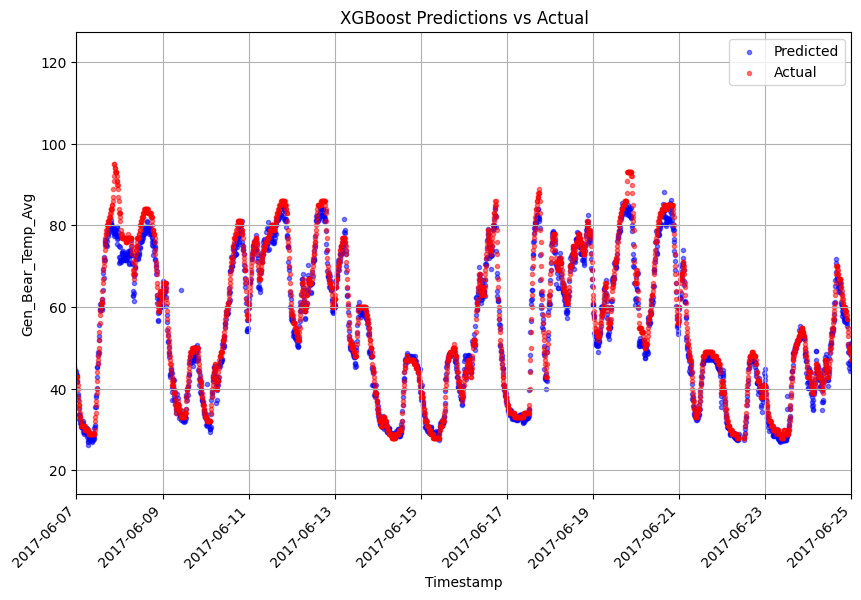

In [91]:
# Adjust figure size as needed
merged_df_filtered17_sorted = merged_df_filtered17.sort_values(by="Timestamp")

plt.figure(figsize=(10, 6))

# Scatter plot for predicted values
plt.scatter(merged_df_filtered17["Timestamp"], y_pred_xgboost, c='blue', alpha=0.5, label='Predicted', marker=".")

# Scatter plot for actual values (y_test)
plt.scatter(merged_df_filtered17["Timestamp"], y_test, c='red', alpha=0.5, label='Actual', marker=".")

"""# Plot for predicted values
plt.plot(merged_df_filtered17_sorted["Timestamp"], y_pred_xgboost, color='blue', alpha=0.5, label='Predicted', linestyle='-')

# Plot for actual values (y_test)
plt.plot(merged_df_filtered17_sorted["Timestamp"], y_test, color='red', alpha=0.5, label='Actual', linestyle='-')
"""

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for data
plt.xlim(pd.Timestamp('2017-06-07'), pd.Timestamp('2017-06-25'))

plt.title("XGBoost Predictions vs Actual")
plt.xlabel("Timestamp")
plt.ylabel("Gen_Bear_Temp_Avg")
plt.legend()  # Show legend to distinguish between predicted and actual values
plt.grid(True)
plt.show()

Luckily the model looks to capture the temperature change! When comparing with previous research

# Ending notes notes and rest of the project
With this we hope you got a feel for our thoughs behind the project. The rest of the project is mostly built the same but with different models and a variation of the same principles introduced in this notebook. 

For the next documents CSV files will be used, because they make it way faster to process than excel files. 